In [1]:
from sklearn.model_selection import train_test_split
from transformers import GPT2Tokenizer, GPT2LMHeadModel, Trainer, TrainingArguments
from src.load_dataloader import initial_dataloader
import random
from transformers import T5ForConditionalGeneration, T5Tokenizer, AdamW, Trainer, TrainingArguments
import torch
from torch.utils.data import Dataset, DataLoader

In [2]:
import pandas as pd
from torch.optim import AdamW
from transformers import get_scheduler
import torch.nn as nn
from src.load_dataloader import initial_dataloader
from src.evaluation import evaluate
from src.evaluation import evaluate_process
from src.load_config import load_config
from src.evaluation import show_sentence
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

max_length = 128

In [3]:
df = pd.read_csv('datasets_combine.csv')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Dataset class
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=False,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

# LSTM Classifier Model
class LSTMClassifier(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocab_size, output_dim):
        super(LSTMClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, input_ids):
        embedded = self.embedding(input_ids)
        lstm_out, (hidden, _) = self.lstm(embedded)
        out = self.fc(hidden[-1])
        return out

def validate(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct_predictions = 0
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            labels = batch['label'].to(device)
            outputs = model(input_ids)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, predicted = torch.max(outputs, dim=1)
            correct_predictions += (predicted == labels).sum().item()

    avg_loss = total_loss / len(val_loader)
    accuracy = correct_predictions / len(val_loader.dataset)
    return avg_loss, accuracy

In [4]:
# Model hyperparameters
EMBEDDING_DIM = 100
HIDDEN_DIM = 128
OUTPUT_DIM = 2  # Adjust based on the number of target classes
num_epoch = 8

# Initialize T5 tokenizer
tokenizer = T5Tokenizer.from_pretrained('t5-small')
VOCAB_SIZE = tokenizer.vocab_size

# Prepare the dataset and dataloader
train_texts, val_texts, train_labels, val_labels = train_test_split(df['sentence'], df['label'], test_size=0.2)
train_dataset = TextDataset(train_texts.tolist(), train_labels.tolist(), tokenizer, max_length=128)
val_dataset = TextDataset(val_texts.tolist(), val_labels.tolist(), tokenizer, max_length=128)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Initialize the model
model = LSTMClassifier(EMBEDDING_DIM, HIDDEN_DIM, VOCAB_SIZE, OUTPUT_DIM).to(device)

# Training setup
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
for epoch in range(num_epoch):  # Number of epochs
    model.train()
    total_loss = 0
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        labels = batch['label'].to(device)
        optimizer.zero_grad()
        predictions = model(input_ids)
        loss = criterion(predictions, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    val_loss, val_accuracy = validate(model, val_loader, criterion, device)
    print(f'Epoch: {epoch + 1}, Loss: {total_loss / len(train_loader)}')
    print(f'Val Loss: {val_loss}, Val Accuracy: {val_accuracy}')
# Save the model
torch.save(model.state_dict(), 'lstm_model.pth')

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Epoch: 1, Loss: 0.5498777725839916
Val Loss: 0.23187401570906543, Val Accuracy: 0.915689381933439
Epoch: 2, Loss: 0.13815106071201683
Val Loss: 0.1073969624221626, Val Accuracy: 0.9683042789223455
Epoch: 3, Loss: 0.07179071160056923
Val Loss: 0.06413076802937671, Val Accuracy: 0.9797147385103011
Epoch: 4, Loss: 0.03929475705298489
Val Loss: 0.06370895389100593, Val Accuracy: 0.979080824088748
Epoch: 5, Loss: 0.02506931848040063
Val Loss: 0.07122243704001485, Val Accuracy: 0.9806656101426308
Epoch: 6, Loss: 0.01704397446393401
Val Loss: 0.07518824800082266, Val Accuracy: 0.9778129952456418
Epoch: 7, Loss: 0.01147466062367717
Val Loss: 0.06775978596991568, Val Accuracy: 0.9828843106180666
Epoch: 8, Loss: 0.009766250411549559
Val Loss: 0.06714207571613687, Val Accuracy: 0.9847860538827259


In [5]:
!pip install sentencepiece

In [6]:
def predict(text, model=model, tokenizer=tokenizer, device=device):
    model.eval()
    with torch.no_grad():
        encoding = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=128,
            padding='max_length',
            truncation=True,
            return_attention_mask=False,
            return_tensors='pt'
        )
        input_ids = encoding['input_ids'].flatten().to(device)
        outputs = model(input_ids)

        # normalize the scores to all positive and sum to 1
        outputs = torch.nn.functional.softmax(outputs, dim=0)

        return outputs

In [7]:
tokenizer_GPT2 = GPT2Tokenizer.from_pretrained('gpt2')
model_GPT = GPT2LMHeadModel.from_pretrained('gpt2')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
if tokenizer_GPT2.pad_token_id is None:
    tokenizer_GPT2.pad_token_id = tokenizer_GPT2.eos_token_id

def show_sentence(index, test_df, tokenizer_GPT2, model, device, max_length):
    model.eval()
    with torch.no_grad():
        source_sentence = test_df.iloc[index]['input_text']
        target_sentence = test_df.iloc[index]['target_text']
        input_text = f"transform the written style of {source_sentence} to the written style of {target_sentence}"
        input_ids = tokenizer_GPT2.encode(input_text, return_tensors='pt')
        outputs = model.generate(input_ids=input_ids, pad_token_id=tokenizer_GPT2.pad_token_id, max_length=max_length, num_beams=10, early_stopping=True)
        transformed_sentence = tokenizer_GPT2.decode(outputs[0], skip_special_tokens=True)

        print("Original Sentence: " + source_sentence)
        print("Target Sentence style: " + target_sentence)
        print("Generated Sentence: " + transformed_sentence)
        print("===========================")

In [9]:
df = pd.read_csv('datasets_combine.csv')
if tokenizer_GPT2.pad_token is None:
    tokenizer_GPT2.add_special_tokens({'pad_token': '[PAD]'})
    model.resize_token_embeddings(len(tokenizer_GPT2))
train_df, val_df,test_df, train_dataset,val_dataset, test_dataset,train_loader, val_loader, test_loader = initial_dataloader(df, tokenizer_GPT2, max_length)

In [10]:
for i in range(3):
    show_sentence(i, test_df, tokenizer_GPT2, model_GPT, device, max_length)

Original Sentence: Sirrah, go hire me twenty cunning cooks
Target Sentence style: He survived, but went into  depression and 'felt like he couldn't go on'Found dead in October last year in same room where wife passed away
Generated Sentence: transform the written style of Sirrah, go hire me twenty cunning cooks to the written style of He survived, but went into  depression and 'felt like he couldn't go on'Found dead in October last year in same room where wife passed away.
Original Sentence: O happy dagger!This is thy sheath;there rust, and let me die
Target Sentence style: Overwhelming evidence of increased use of legal high nitrous oxide
Generated Sentence: transform the written style of O happy dagger!This is thy sheath;there rust, and let me die to the written style of Overwhelming evidence of increased use of legal high nitrous oxide!This is thy sheath;there rust, and let me die to the written style of Overwhelming evidence of increased use of legal high nitrous oxide!This is thy 

In [11]:
def generate_sentence(index, test_df, tokenizer_GPT2, model, device, max_length):
    try:
      model.eval()
      with torch.no_grad():
          source_sentence = test_df.iloc[index]['input_text']
          target_sentence = test_df.iloc[index]['target_text']
          input_text = f"transform the written style of {source_sentence} to the written style of {target_sentence}"
          input_ids = tokenizer_GPT2.encode(input_text, return_tensors='pt')
          outputs = model.generate(input_ids=input_ids, pad_token_id=tokenizer_GPT2.pad_token_id, max_length=max_length, num_beams=10, early_stopping=True)
          transformed_sentence = tokenizer_GPT2.decode(outputs[0], skip_special_tokens=True)

          print("Original Sentence: " + source_sentence)
          print("Target Sentence style: " + target_sentence)
          print("Generated Sentence: " + transformed_sentence)
          print("===========================")
          return transformed_sentence
    except:
      return None

In [21]:
test_df_new = test_df.copy()
test_df_new = test_df_new.reset_index(drop=True)
if 'generated_sentences' not in test_df_new.columns:
    test_df_new['generated_sentences'] = None
for index, row in test_df_new.iterrows():
    generated_text = generate_sentence(index, test_df_new, tokenizer_GPT2, model_GPT, device, max_length)
    test_df_new.loc[index, 'generated_sentences'] = generated_text

Original Sentence: Sirrah, go hire me twenty cunning cooks
Target Sentence style: He survived, but went into  depression and 'felt like he couldn't go on'Found dead in October last year in same room where wife passed away
Generated Sentence: transform the written style of Sirrah, go hire me twenty cunning cooks to the written style of He survived, but went into  depression and 'felt like he couldn't go on'Found dead in October last year in same room where wife passed away.
Original Sentence: O happy dagger!This is thy sheath;there rust, and let me die
Target Sentence style: Overwhelming evidence of increased use of legal high nitrous oxide
Generated Sentence: transform the written style of O happy dagger!This is thy sheath;there rust, and let me die to the written style of Overwhelming evidence of increased use of legal high nitrous oxide!This is thy sheath;there rust, and let me die to the written style of Overwhelming evidence of increased use of legal high nitrous oxide!This is thy 

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 141, but `max_length` is set to 128. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(


Original Sentence: It cost $20b to build, and employs a staff of 20,000
Target Sentence style: MIRANDA:I might call himA thing divine, for nothing naturalI ever saw so noble
Generated Sentence: transform the written style of It cost $20b to build, and employs a staff of 20,000 to the written style of MIRANDA:I might call himA thing divine, for nothing naturalI ever saw so noble a man as that of MIRANDA. He was a man of the heart, a man of the heart, a man of the heart, a man of the heart, a man of the heart, a man of the heart, a man of the heart, a man of the heart, a man of the heart, a man of the heart, a man of the heart, a man of
Original Sentence: But O, the noblecombat that 'twixt joy and sorrow was fought inPaulina! She had one eye declined for the loss ofher husband, another elevated that the oracle wasfulfilled: she lifted the princess from the earth,and so locks her in embracing, as if she would pinher to her heart that she might no more be in dangerof losing
Target Sentence

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 128, but `max_length` is set to 128. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(


Original Sentence: military strategy which will focus more on Asia
Target Sentence style: BAPTISTA:I know him well: you are welcome for his sake
Generated Sentence: transform the written style of military strategy which will focus more on Asia to the written style of BAPTISTA:I know him well: you are welcome for his sake, but you are not welcome for BAPTISTA:I know him well: you are welcome for his sake, but you are not welcome for BAPTISTA:I know him well: you are welcome for his sake, but you are not welcome for BAPTISTA:I know him well: you are welcome for his sake, but you are not welcome for BAPTISTA:I know him well: you are welcome
Original Sentence: KING HENRY VI:Ay, and for much more slaughter after this
Target Sentence style: Parker will play for Bucks against New York Knicks in London in January
Generated Sentence: transform the written style of KING HENRY VI:Ay, and for much more slaughter after this to the written style of Parker will play for Bucks against New York Knicks 

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 133, but `max_length` is set to 128. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(


Original Sentence: Only Robin van Persie has scored in more (nine) consecutive away games
Target Sentence style: You say, seven years together?ELBOW:And a half, sir
Generated Sentence: transform the written style of Only Robin van Persie has scored in more (nine) consecutive away games to the written style of You say, seven years together?ELBOW:And a half, sir?ELBOW:And a half, sir?ELBOW:And a half, sir?ELBOW:And a half, sir?ELBOW:And a half, sir?ELBOW:And a half, sir?ELBOW:And a half, sir?ELBOW:And a half, sir?ELBOW:And a half, sir?ELBOW:And a
Original Sentence: Marissa Wilmoth, 7, died after wooden beam from play set fell on her head
Target Sentence style: HERMIONE:I had thought, sir, to have held my peace untilYou have drawn oaths from him not to stay
Generated Sentence: transform the written style of Marissa Wilmoth, 7, died after wooden beam from play set fell on her head to the written style of HERMIONE:I had thought, sir, to have held my peace untilYou have drawn oaths from him 

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 233, but `max_length` is set to 128. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(


Original Sentence: LORD WILLOUGHBY:Base men by his endowments are made great
Target Sentence style: Test flight with people on board will take place later this year
Generated Sentence: transform the written style of LORD WILLOUGHBY:Base men by his endowments are made great to the written style of Test flight with people on board will take place later this year.
Original Sentence: ABRAHAM:Do you bite your thumb at us, sir?SAMPSON:I do bite my thumb, sir
Target Sentence style: Bestival theme this year is nautical: HMS Bestival
Generated Sentence: transform the written style of ABRAHAM:Do you bite your thumb at us, sir?SAMPSON:I do bite my thumb, sir to the written style of Bestival theme this year is nautical: HMS Bestival.SAMPSON:I do bite my thumb at us, sir?SAMPSON:I do bite my thumb at us, sir?SAMPSON:I do bite my thumb at us, sir?SAMPSON:I do bite my thumb at us, sir?SAMPSON:I do bite my thumb at us, sir?SAMPSON:I do bite my thumb at
Original Sentence: Drake is now eight-months-old 

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 203, but `max_length` is set to 128. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(


Original Sentence: The smallest worm will turn being trodden on,And doves will peck in safeguard of their brood
Target Sentence style: Charged with using fake document as form of ID in December
Generated Sentence: transform the written style of The smallest worm will turn being trodden on,And doves will peck in safeguard of their brood to the written style of Charged with using fake document as form of ID in December.
Original Sentence: Mayor:True, my good lord; I know you for no less
Target Sentence style: Christopher Tomkins, who inspected flat, told police he was 'electrician's mate'He and supervisor Neil Hoult plead not guilty to breaching Health & Safety
Generated Sentence: transform the written style of Mayor:True, my good lord; I know you for no less to the written style of Christopher Tomkins, who inspected flat, told police he was 'electrician's mate'He and supervisor Neil Hoult plead not guilty to breaching Health & Safety Act by failing to register as a sex offender and fail

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 148, but `max_length` is set to 128. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(


Original Sentence: The women used their looks, in disparate ways, to gain public attention
Target Sentence style: ANGELO:Well, let her be admitted
Generated Sentence: transform the written style of The women used their looks, in disparate ways, to gain public attention to the written style of ANGELO:Well, let her be admitted that she is a beautiful woman, but she is not a beautiful woman. Let her be admitted that she is a beautiful woman, but she is not a beautiful woman. Let her be admitted that she is a beautiful woman, but she is not a beautiful woman. Let her be admitted that she is a beautiful woman, but she is not a beautiful woman. Let her be admitted that she is a beautiful woman, but she is not a beautiful woman. Let her be admitted
Original Sentence: Camaraderie of performing important to actor
Target Sentence style: The sight of any of the house of YorkIs as a fury to torment my soul;And till I root out their accursed lineAnd leave not one alive, I live in hell
Generated Sen

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 170, but `max_length` is set to 128. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(


Original Sentence: Adam Kerber lost control of the vehicle while driving on a Kanzas highway
Target Sentence style: HENRY BOLINGBROKE:Call forth Bagot
Generated Sentence: transform the written style of Adam Kerber lost control of the vehicle while driving on a Kanzas highway to the written style of HENRY BOLINGBROKE:Call forth Bagot in the form of HENRY BOLINGBROKE:HENRY BOLINGBROKE:HENRY BOLINGBROKE:HENRY BOLINGBROKE:HENRY BOLINGBROKE:HENRY BOLINGBROKE:HENRY BOLINGBROKE:HENRY BOLINGBROKE:HENRY B
Original Sentence: D is for DRM, technologies companies use to try to restrict online piracy
Target Sentence style: Come, let's go:I am the king's friend, and will rid his foe
Generated Sentence: transform the written style of D is for DRM, technologies companies use to try to restrict online piracy to the written style of Come, let's go:I am the king's friend, and will rid his foe of me.
Original Sentence: What!An advocate for an imposter! hush!Thou think'st there is no more such shapes as he

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 132, but `max_length` is set to 128. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(


Original Sentence: ROMEO:Here's goodly gear!MERCUTIO:A sail, a sail!BENVOLIO:Two, two; a shirt and a smock
Target Sentence style: The Brazil defender has also won the Champions League twice with Barca
Generated Sentence: transform the written style of ROMEO:Here's goodly gear!MERCUTIO:A sail, a sail!BENVOLIO:Two, two; a shirt and a smock to the written style of The Brazil defender has also won the Champions League twice with Barca.
Original Sentence: Fare you well
Target Sentence style: He crashed into a patrol car while driving through suburban Atlanta
Generated Sentence: transform the written style of Fare you well to the written style of He crashed into a patrol car while driving through suburban Atlanta.

Fare is one of the most popular novels of the 20th century. It is one of the most popular novels of the 20th century. It is one of the most popular novels of the 20th century. It is one of the most popular novels of the 20th century. It is one of the most popular novels of the 20t

In [22]:
test_df_new = test_df_new.dropna()

In [23]:
def label_generated_text_pred(sentence):
    label_prob = predict(sentence, model, tokenizer, device)
    if label_prob.tolist()[0] > 0.5:
        label = 0
    else:
        label = 1
    return label
test_df_new['label_generated_pred'] = test_df_new['generated_sentences'].apply(label_generated_text_pred)

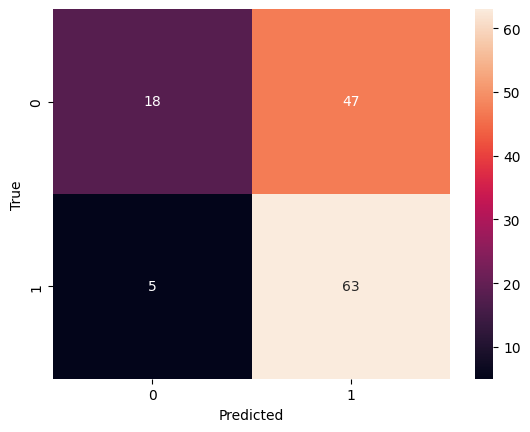

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_df_new['transform_style'], test_df_new['label_generated_pred'])
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

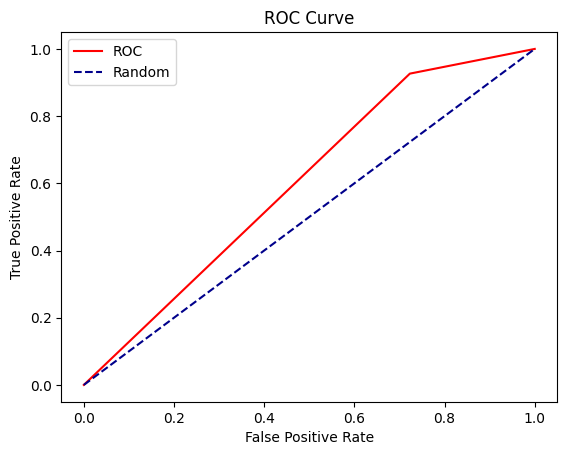

In [26]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
predict = test_df_new['label_generated_pred']
True_label = test_df_new['transform_style']
fpr, tpr, thresholds = roc_curve(True_label, predict)
auc = roc_auc_score(True_label, predict)
plt.plot(fpr, tpr, color='red', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [27]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(True_label, predict)
print(f"Accuracy: {accuracy}")

Accuracy: 0.6090225563909775


In [28]:
print(f'AUC: {auc}')

AUC: 0.6016968325791856
